### Ibad Ur Rahman
### 23MDBCS421
### Data Science
### Semester 5th
### Lab Task 11
### Dr.Tariq Sadad

In [5]:
from collections import defaultdict

# edge_dict is the dictionary of edge connections
edge_dict = defaultdict(lambda: [])

edge_dict['A'].extend(['B','C'])
edge_dict['B'].extend(['A','D','E'])
edge_dict['C'].extend(['A','D'])
edge_dict['D'].extend(['B','C','F'])
edge_dict['E'].extend(['B','G','H'])
edge_dict['F'].extend(['D','G','H'])
edge_dict['G'].extend(['E','F','I'])
edge_dict['H'].extend(['E','F','I'])
edge_dict['I'].extend(['G','H'])

In [6]:
edge_dict

defaultdict(<function __main__.<lambda>()>,
            {'A': ['B', 'C'],
             'B': ['A', 'D', 'E'],
             'C': ['A', 'D'],
             'D': ['B', 'C', 'F'],
             'E': ['B', 'G', 'H'],
             'F': ['D', 'G', 'H'],
             'G': ['E', 'F', 'I'],
             'H': ['E', 'F', 'I'],
             'I': ['G', 'H']})

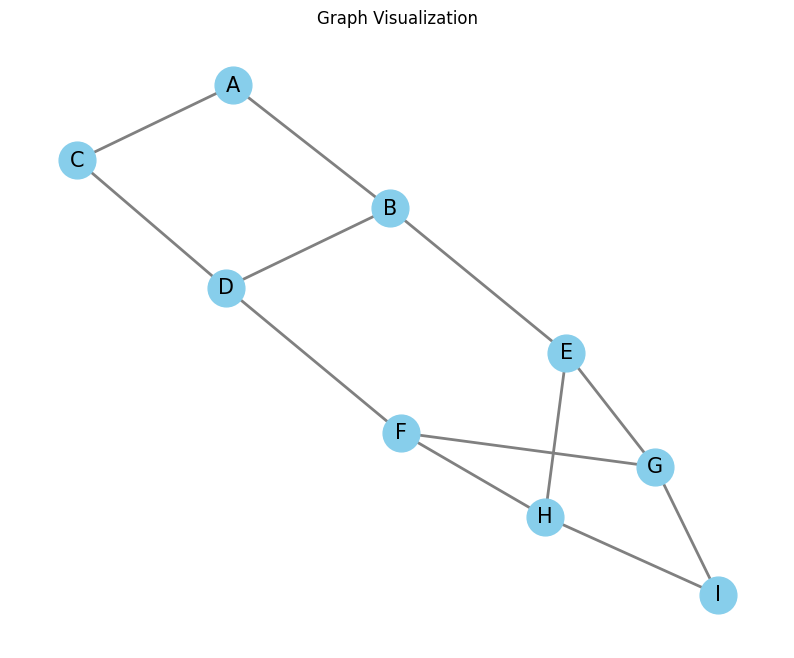

In [7]:
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict

# Create the edge dictionary
edge_dict = defaultdict(lambda: [])
edge_dict['A'].extend(['B','C'])
edge_dict['B'].extend(['A','D','E'])
edge_dict['C'].extend(['A','D'])
edge_dict['D'].extend(['B','C','F'])
edge_dict['E'].extend(['B','G','H'])
edge_dict['F'].extend(['D','G','H'])
edge_dict['G'].extend(['E','F','I'])
edge_dict['H'].extend(['E','F','I'])
edge_dict['I'].extend(['G','H'])

# Create a NetworkX graph from the edge dictionary
G = nx.Graph()
for node, neighbors in edge_dict.items():
    for neighbor in neighbors:
        G.add_edge(node, neighbor)

# Draw the graph
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42)  # consistent layout

# nodes
nx.draw_networkx_nodes(G, pos, node_size=700, node_color="skyblue")

# edges
nx.draw_networkx_edges(G, pos, width=2, edge_color="gray")

# labels
nx.draw_networkx_labels(G, pos, font_size=15, font_family="sans-serif")

plt.title("Graph Visualization")
plt.axis("off")
plt.show()


In [8]:
# Function to scale betweenness
def scale_DAG_btw_dict(edge_btw_dict):
    for e in edge_btw_dict:
        edge_btw_dict[e] /= 2
    return edge_btw_dict

# Function to calculate betweenness and communities
def calculate_btw_and_communities(edge_dict, vertices):
    edge_btw_dict = defaultdict(lambda: 0)
    com_res = set()

    for v in vertices:
        visited = []
        src = [v]
        node_score = defaultdict(lambda: [0, 1])
        node_score[v][0] += 1
        edge_path = []

        while True:
            visited.extend(src)
            next_src = set()
            cur_level_edge = defaultdict(list)
            for node in src:
                for next_node in edge_dict[node]:
                    if next_node not in visited:
                        next_src.add(next_node)
                        node_score[next_node][0] += node_score[node][0]
                        cur_level_edge[next_node].append(node)

            if len(next_src) == 0:
                if v not in edge_dict:
                    com_res.add(tuple([v]))
                else:
                    com_res.add(tuple(sorted(visited)))
                break
            else:
                edge_path.append(cur_level_edge)
                src = next_src

        # Compute betweenness for edges
        for indx in range(len(edge_path)-1, -1, -1):
            level_nodes = edge_path[indx]
            for node in level_nodes:
                for next_node in level_nodes[node]:
                    btw_val = node_score[node][1] * node_score[next_node][0] / node_score[node][0]
                    edge_btw_dict[tuple(sorted([node, next_node]))] += btw_val
                    node_score[next_node][1] += btw_val

    edge_btw_dict = scale_DAG_btw_dict(edge_btw_dict)
    return edge_btw_dict, com_res

# Run calculation
edge_btw_dict, communities = calculate_btw_and_communities(edge_dict, list(edge_dict.keys()))

# Display results
print("Edge Betweenness:")
for edge, btw in edge_btw_dict.items():
    print(f"{edge}: {btw:.2f}")

print("\nDetected Communities:")
for com in communities:
    print(com)

Edge Betweenness:
('G', 'I'): 4.33
('H', 'I'): 4.33
('E', 'G'): 5.33
('E', 'H'): 5.33
('D', 'F'): 10.00
('B', 'D'): 5.00
('C', 'D'): 7.00
('B', 'E'): 10.00
('A', 'B'): 7.00
('A', 'C'): 3.00
('F', 'G'): 5.33
('F', 'H'): 5.33

Detected Communities:
('A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I')


In [9]:
def compute_modularity(original_graph, update_graph, m, communities):
    res = 0
    for com in communities:
        for edge in itertools.combinations(com, 2):
            A = 0
            v1, v2 = edge
            if v1 in original_graph[v2] and v2 in original_graph[v1]:
                A = 1
            ki = len(update_graph[v1])
            kj = len(update_graph[v2])
            res += A - (ki * kj) / (2 * m)
    return res / (2 * m)

def remove_highest_btw_edge(edge_dict, edge_btw_dict):
    largest_key = max(edge_btw_dict, key=lambda x: edge_btw_dict[x])
    remove_key_list = [e for e in edge_btw_dict if round(edge_btw_dict[e], 5) == round(edge_btw_dict[largest_key], 5)]
    print(f"Removing edges {remove_key_list} with betweenness ~ {edge_btw_dict[largest_key]:.2f}")
    for e in remove_key_list:
        if e[1] in edge_dict[e[0]]:
            edge_dict[e[0]].remove(e[1])
        if e[0] in edge_dict[e[1]]:
            edge_dict[e[1]].remove(e[0])
    return edge_dict

def compute_opt_communities(edge_dict, vertices, verbose=True):
    max_modularity = float('-inf')
    edge_set = set()
    for k in edge_dict:
        edge_set.update([tuple(sorted([k, j])) for j in edge_dict[k]])
    edge_count = len(edge_set)
    update_graph = deepcopy(edge_dict)

    edge_btw_dict, current_best_community = calculate_btw_and_communities(edge_dict, vertices)

    while True:
        update_graph = remove_highest_btw_edge(update_graph, edge_btw_dict)
        edge_btw_dict, next_community = calculate_btw_and_communities(update_graph, vertices)
        cur_modularity = compute_modularity(edge_dict, update_graph, edge_count, next_community)

        if cur_modularity >= max_modularity:
            if verbose:
                print(f"Updated best modularity: {max_modularity:.4f} --> {cur_modularity:.4f}\n")
            max_modularity = cur_modularity
            current_best_community = next_community
        else:
            if verbose:
                print(f"Modularity after split = {cur_modularity:.4f}, lower than best {max_modularity:.4f}. Stopping.\n")
            break

    return current_best_community

# Run the optimized community detection
best_community = compute_opt_communities(edge_dict, list(edge_dict.keys()))

# Display detected communities
print("Best community split detected:")
for com in best_community:
    print(com)

Removing edges [('D', 'F'), ('B', 'E')] with betweenness ~ 10.00
Updated best modularity: -inf --> 0.2760

Removing edges [('F', 'G'), ('F', 'H'), ('G', 'I'), ('H', 'I'), ('E', 'G'), ('E', 'H')] with betweenness ~ 2.33
Modularity after split = 0.1250, lower than best 0.2760. Stopping.

Best community split detected:
('E', 'F', 'G', 'H', 'I')
('A', 'B', 'C', 'D')
